# Tutorial: The Canonical HANK Model & Fiscal Policy

This file has blanks that we will fill in the tutorial together.

This notebook aims to provide a step-by-step tutorial on how to set up the canonical HANK model from scratch using `sequence-jacobian` and then proceeding to compute some simple impulse responses.

The first step is to import packages we'll need for this notebook.

In [1]:
import numpy as np  # numpy helps us perform linear algebra calculations
import matplotlib.pyplot as plt  # helps us plot
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc
import pickle
from ConsIndShockModel_HANK import IndShockConsumerType
from scipy import optimize

from sequence_jacobian import het, simple, create_model              # functions


In [2]:
#Steady State values

def fiscal_ss(B, r, G): 
    T = (1 + r) * B + G - B
    
    return T

r_ss = 1.03 - 1
G_ss = .2
B_ss = .5 # this is lower than the tutorial by Straub et al. because need Higher MPC
Y_ss = 1.0


T_ss = fiscal_ss(B_ss,r_ss,G_ss)

print('T_ss: ' +str(T_ss))

Z_ss = Y_ss - T_ss

C_ss= Y_ss - G_ss
print('Z_ss: ' +str(Z_ss))

print('C_ss: ' +str(Y_ss - G_ss))

tau = 0.0

T_ss: 0.21500000000000008
Z_ss: 0.7849999999999999
C_ss: 0.8


In [3]:
#------------------------------------------------------------------------------------------------------
Dict = {
    # Parameters shared with the perfect foresight model
    "CRRA":2,                              # Coefficient of relative risk aversion
    "Rfree": 1+r_ss,                    # Interest factor on assets
    "DiscFac": 0.96,                      # Intertemporal discount factor
    "LivPrb" : [.99375],                   # Survival probability
    "PermGroFac" : [1.00],                 # Permanent income growth factor

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [.2],                   # Standard deviation of log transitory shocks to income
    "TranShkCount" : 7,    
    
    # HANK params
    "taxrate" : [tau], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Y_ss - T_ss],
    "wage": [1.0],
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.0,                      # Probability of unemployment while working
    "IncUnemp" :  0.0,                     # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.0000,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 0.0,                      # Period of retirement (0 --> no retirement)
    "tax_rate" : 0.0,                      # Flat income tax rate (legacy parameter, will be removed in future)

    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.0001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 1000,                       # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 110,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid

    # A few other parameters
    "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : False,                   # Whether to calculate the value function during solution
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 1,                         # Number of periods in the cycle for this agent type 
}

# HARK Consumer

In [4]:


def function(taxrate,labor,wage):
    
    z = (1 - taxrate)*labor*wage
    
    return z


Dict['TranShkMean_Func'] = [function]

Agent = IndShockConsumerType(**Dict, verbose = False)


In [5]:
Agent.compute_steady_state()

(0.4409741754286364, 0.7967342040085448)

In [6]:
CJACR,AJACR = Agent.calc_jacobian('Rfree',200)

In [7]:
plt.plot(CJACR.T[30])
plt.plot(CJACR.T[0])
plt.plot(CJACR.T[50])

In [8]:
CJACN,AJACN = Agent.calc_jacobian('labor', 200)

No handles with labels found to put in legend.


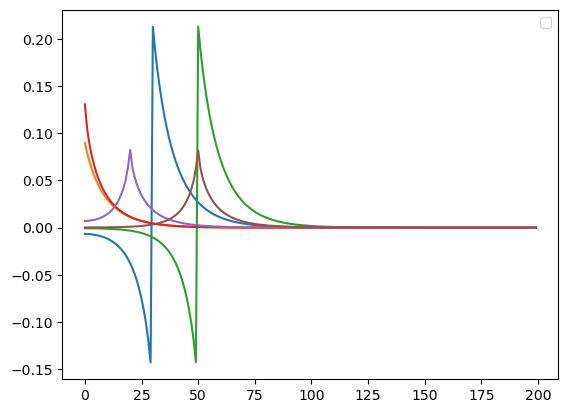

In [9]:
plt.plot(CJACN.T[0])
plt.plot(CJACN.T[20])
plt.plot(CJACN.T[50])
plt.legend()
plt.show()

In [10]:
#%% find steady state

Asset_target = B_ss
def ss_func(beta):
    Agent.DiscFac = beta
    A_ss = Agent.compute_steady_state()[0]
    
    return A_ss
    

def ss_dif(beta):
    
    return ss_func(beta) - Asset_target 


DiscFac = optimize.brentq(ss_dif,.8,.99)


Agent.DiscFac = DiscFac




#%%

Dict['DiscFac'] = DiscFac

A_ss = IndShockConsumerType(**Dict,verbose = False)
#Agent.cycles = 0
#Agent.aXtraCount = 300

Agent.compute_steady_state()


print('beta:' +str(Agent.DiscFac))
#verify
print('Assets: ' +str(Agent.A_ss))
print('Consumption: ' + str(Agent.C_ss))


beta:0.9677910107381233
Assets: 0.5000000000171765
Consumption: 0.798125000000451


In [11]:
@sj.simple
def fiscal(B, r, G, Y): 
    T = (1 + r) * B(-1) + G - B
    Z = Y - T
    
    deficit = G - T
    
    return T,Z, deficit

@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = C + G - Y
    
    return asset_mkt, goods_mkt


In [12]:
from sequence_jacobian.classes import JacobianDict

HA_Jacobian_Dict = JacobianDict( { 'C' : {'Z' : CJACN} ,'A' : {'Z' : AJACN} } )

In [13]:
HA_Jacobian_Dict

<JacobianDict outputs=['C', 'A'], inputs=['Z']>

In [14]:
HA_Jacobian_Dict['A']

{'Z': array([[ 7.39364821e-01, -1.20785474e-01, -9.69021894e-02, ...,
         -2.43239903e-11, -2.17246236e-11, -1.92311649e-11],
        [ 6.52031710e-01,  7.39364821e-01, -2.03078181e-01, ...,
         -4.94810061e-11, -4.41545429e-11, -3.93450401e-11],
        [ 5.78444568e-01,  6.52031711e-01,  6.68540324e-01, ...,
         -7.59024119e-11, -6.77376029e-11, -6.03837483e-11],
        ...,
        [ 1.36912703e-08,  2.05530155e-08,  2.05221269e-08, ...,
          4.26418631e-01, -4.74227574e-01, -4.01579070e-01],
        [ 1.21441746e-08,  1.88702069e-08,  1.88417223e-08, ...,
          3.73611289e-01,  4.26418631e-01, -4.74227574e-01],
        [ 1.07208686e-08,  1.73253714e-08,  1.72991022e-08, ...,
          3.29830657e-01,  3.73611289e-01,  4.26418631e-01]])}

In [16]:
# Add steady state dictionary
HA_Jacobian_Dict._steady_state = {
    None
}

In [18]:
ss_Toy_HANK = create_model([HA_Jacobian_Dict,fiscal,mkt_clearing])
unknowns = ['Y']
targets = ['asset_mkt']
inputs = ['G']


Dict_Toy_HANK = {"G": 1.0, "asset_mkt":0.0, "C": C_ss,"r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss }


Dict_Toy_HANK

{'G': 0.2,
 'asset_mkt': 0.0,
 'C': 0.8,
 'r': 0.030000000000000027,
 'Y': 1.0,
 'B': 0.5,
 'A': <ConsIndShockModel_HANK.IndShockConsumerType object at 0x1d0da84a430.
 Parameters:
 cycles: 1
 CRRA: 2
 Rfree: 1.03
 DiscFac: 0.9677910107381233
 LivPrb: [0.99375]
 PermGroFac: [1.0]
 BoroCnstArt: 0.0
 MaxKinks: 400
 AgentCount: 10000
 aNrmInitMean: 0.0
 aNrmInitStd: 1.0
 pLvlInitMean: 0.0
 pLvlInitStd: 0.0
 PermGroFacAgg: 1.0
 T_age: None
 T_cycle: 1
 PerfMITShk: False
 aXtraMin: 0.0001
 aXtraMax: 1000
 aXtraNestFac: 3
 aXtraCount: 110
 aXtraExtra: [None]
 PermShkStd: [0.06]
 PermShkCount: 7
 TranShkStd: [0.2]
 TranShkCount: 7
 UnempPrb: 0.0
 UnempPrbRet: 0.0
 IncUnemp: 0.0
 IncUnempRet: 0.0
 tax_rate: 0.0
 T_retire: 0.0
 vFuncBool: False
 CubicBool: False
 neutral_measure: False
 NewbornTransShk: False
 taxrate: [0.0]
 labor: [0.7849999999999999]
 wage: [1.0]
 TranShkMean_Func: [<function function at 0x000001D0D82AB820>]>}

In [20]:
ss_Toy_HANK

<Model 'fiscal_to_mkt_clearing_combined'>

In [19]:
ss_Toy_HANK = ss_Toy_HANK.steady_state(Dict_Toy_HANK)



AttributeError: 'JacobianDictBlock' object has no attribute '_steady_state'

In [22]:
G_std = 0.01
G_persistence = 0.8
T = 200
regular_Z_shock_path = {"G": G_std*G_persistence**np.arange(T)}

NameError: name 'Toy_SAM' is not defined

In [ ]:
IPR = Toy_SAM.solve_impulse_linear(ss_Toy_HANK, unknowns, targets, regular_Z_shock_path)


Before we start, we'll define some basic model parameters we need below. We store them in the `calibration` dictionary:

In [ ]:
calibration = {'eis': 0.5,  # EIS
               'rho_e': 0.9,  # Persistence of idiosyncratic productivity shocks
               'sd_e': 0.92,  # Standard deviation of idiosyncratic productivity shocks
               'G': 0.2,  # Government spending
               'B': 0.8,  # Government debt
               'Y': 1.,  # Output
               'min_a': 0.,  # Minimum asset level on the grid
               'max_a': 1_000,  # Maximum asset level on the grid
               'n_a': 200,  # Number of asset grid points
               'n_e': 10}  # Number of productivity grid points

## Building the canonical HA Model

### Defining the `HetBlock`

First, we will set up the `HetBlock` that represents our heterogeneous household problem.

For the sake of clarity, we directly write these in the code block below, but since it's a really standard `Block`, we can also import it directly from within `sequence-jacobian` by calling `from sj.hetblocks.hh_sim import hh_init, hh`.

 - `hh_init` initializies the values for the backward iteration, which is `Va`, the derivative of the value function with respect to assets, defined over a joint grid of income and asset states. We always write the grids as (income state, asset state).
 - `hh` is a single backward step of the endogenous gridpoints method, covered in an earlier session.
 - the decorator `@sj.het` turns the subsequent function definition into a `HetBlock`. We'll have similar decorators below to define blocks.

In [ ]:
sj.hetblocks.hh_sim.hh_init

We just created our first block! Let's check it out.

In [ ]:

# initialize the marginal value function

def hh_init(a_grid, z, r, eis):
    
    coh = (1+r)*a_grid[np.newaxis, :] +z[:, np.newaxis]
    Va = (1+r)*(.1*coh)**(-1/eis)
    
    return Va

# backward step

@sj.het(exogenous = 'Pi',
       policy = 'a',
       backward = 'Va',
       backward_init = hh_init)


def hh(Va_p, a_grid, z, r, beta, eis):
    
    uc_nextgrid = beta*Va_p
    
    c_nextgrid = uc_nextgrid ** (-eis)
    coh = (1+r)* a_grid[np.newaxis,:] + z[:, np.newaxis]
    a = sj.interpolate.interpolate_y(c_nextgrid + a_grid, coh, a_grid) # fast interpolation that exploits monotonicity
    sj.misc.setmin(a, a_grid[0])
    
    c = coh - a
    
    Va = (1+r) * c ** (-1/eis)
    
    return Va, a, c



We see that some of these inputs are vectors, such as `a_grid` and `z`. We typically try to define them within the `HetBlock` itself. We can do so by attaching a `hetinput` function that constructs these inputs "in-house" so to speak.

A `hetinput` is a function, which takes either scalar- or vector-valued inputs that are generated from other upstream `hetinput`s, and yields vector-valued outputs that feed into its associated `HetBlock`.

- `make_grids` instantiates the productivity and assets grids:
    - productivity grid `e_grid` is from the Rouwenhorst method for discretizing AR(1) processes.
    - asset grid `a_grid` uses a non-uniform spacing concentrating grid points near the bottom, where policies exhibit the most curvature.

- `income` converts the productivity grid `e_grid` into the post-tax income grid `z`.

Note: in the `.markov_rouwenhorst` function, we normalize $\mathbb{E}[e] = 1$, which is consistent with the exogenous labor supply $N = 1$ in this model.

We define `hh_extended` as a `HetBlock` that has these additional `hetinputs`.

In [ ]:

def make_grids(rho_e, sd_e, n_e, min_a, max_a, n_a):
    e_grid, _, Pi = sj.grids.markov_rouwenhorst(rho_e, sd_e, n_e)
    a_grid = sj.grids.asset_grid(min_a, max_a, n_a)
    
    return e_grid, Pi, a_grid

def income(Z,e_grid):
    z = Z*e_grid 
    return z

hh_extended = hh.add_hetinputs([make_grids, income])

Let's see what the new block does.

In [ ]:


print(hh_extended)
print(hh_extended.inputs)
print(hh_extended.outputs)



We see that the inputs changed: Now `a_grid` and `e_grid` are no longer inputs. Instead, `Z`, total after tax income, is among the inputs. In fact, `Z` will be the only input that will change in GE in our experiments below.

### Defining the `SimpleBlock`s

Next, we will specify two `SimpleBlock`s that will allow us to close our model: a fiscal policy (government) block and a market clearing block.

Here, we define the fiscal block in terms of government bonds `B`.

In [ ]:

@sj.simple
def fiscal(B, r, G, Y): 
    T = (1 + r) * B(-1) + G - B
    Z = Y - T
    
    deficit = G - T
    
    return T,Z, deficit

@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = C + G - Y
    
    return asset_mkt, goods_mkt



Now we can put these `Block`s together to create a model!

In [ ]:

ha = sj.create_model([hh_extended, fiscal, mkt_clearing], name = "Canonical HA model") 



Let's see what kind of animal `ha` is.

In [ ]:

print(ha)
print(ha.inputs)
print(ha.outputs)


A model is really a `CombinedBlock`, which, like our $H$ function in lecture, itself has inputs and outputs.

Many of the inputs are model parameters, such as `eis`, `beta`, `rho_e`, etc. But some are actually aggregates we want to solve ("unknowns") for or shock ("exogenous inputs"). One nice feature in SSJ is that we don't have to distinguish the two at this point. This gives us flexibility to shock whatever we want later on.

Some of the outputs are "targets", such as `goods_mkt` or `asset_mkt`. By Walras' law, it is sufficient to impose either `asset_mkt` or `goods_mkt`.

## Calibrating a steady state

To solve for a steady state, we need to specify the unknowns that we are calibrating to satisfy the targets of the model. We can omit one of them (`goods_mkt` in this case) for now by Walras' law. We will check its value afterward to ensure our model is correctly specified. If this test fails, we made a mistake when setting up the model.

Because we want to fix the steady state interest rate `r` at a pre-specified value, to satisfy 1) `asset_mkt`, we will calibrate `beta`.

We could try to find the steady state ourselves:

In [ ]:
calibration['r'] = .03
calibration['beta'] = .85

ss = ha.steady_state(calibration)

ss['asset_mkt']  # steady state level of assets


Or we do this automatically, by solving for the `beta` that sets `asset_mkt` to zero.

In [ ]:

unknowns_ss = {'beta': (0.75,.9)}
targets_ss = ['asset_mkt']
ss = ha.solve_steady_state(calibration, unknowns_ss, targets_ss )



Now let's verify that Walras law holds

In [ ]:


print( 'Asset market clearing: ' + str(ss['asset_mkt']))
print( 'goods market clearing: ' + str(ss['goods_mkt']))



In [ ]:
ss['beta']

### Matching MPCs

One important lesson from today's classes was that MPC's are really important, more important than the wealth distribution itself to accurately capture the aggregate dynamics of heterogeneous-agent models. So could we try to match equilibrium MPCs here, too?

To do this, we need to compute MPCs, but those depend on the policy function `c` that lives within the `HetBlock` for now! We see this by checking `hh_extended`'s outputs:

To compute MPCs, we can define a `hetoutput` function:

A `hetoutput` is a function, which takes scalar- and vector-valued inputs provided in the `calibration` or computed within the `HetBlock` it is attached to, and produces vector-valued outputs. A common use case for `hetoutput`s is to compute a quantity that is not necessary as a step in the backward iteration of the `HetBlock` itself but is useful as a target in the model DAG or as an output the user cares to inspect.

Other examples of `hetoutput` functions are functions that compute, e.g. moments of the wealth distribution.

In [ ]:
def compute_weighted_mpc(c, a, a_grid, r, e_grid):
    """Approximate mpc out of wealth, with symmetric differences where possible, exactly setting mpc=1 for constrained agents."""
    mpc = np.empty_like(c)
    post_return = (1 + r) * a_grid
    mpc[:, 1:-1] = (c[:, 2:] - c[:, 0:-2]) / (post_return[2:] - post_return[:-2])
    mpc[:, 0] = (c[:, 1] - c[:, 0]) / (post_return[1] - post_return[0])
    mpc[:, -1] = (c[:, -1] - c[:, -2]) / (post_return[-1] - post_return[-2])
    mpc[a == a_grid[0]] = 1
    mpc = mpc * e_grid[:, np.newaxis]
    return mpc


hh_extended2 = hh_extended.add_hetoutputs([compute_weighted_mpc])

ha = sj.create_model([hh_extended2,fiscal,mkt_clearing], name = 'Canonical HA')

ss = ha.steady_state(ss)

In [ ]:
jha = hh_extended2.jacobian(ss,inputs= ['r', 'Z'], T= 300)

In [ ]:
plt.plot(jha['C']['Z'].T[0])
plt.plot(jha['C']['Z'].T[20])
plt.plot(jha['C']['Z'].T[30])
plt.plot(jha['C']['Z'].T[-1])

In [ ]:
plt.plot(jha['C']['r'].T[0])
plt.plot(jha['C']['r'].T[20])
plt.plot(jha['C']['r'].T[30])
plt.plot(jha['C']['r'].T[-1])

In [ ]:
plt.plot(jha['A']['r'].T[0])
plt.plot(jha['A']['r'].T[20])
plt.plot(jha['A']['r'].T[30])
plt.plot(jha['A']['r'].T[-1])

In [ ]:
sj.drawdag(ha)

What did this do? Let's see how it affected `hh_extended`.

In [ ]:
print(hh_extended2.outputs)



Now we have an MPC variable as output! Let's check what it is in our current calibration by evaluating `hh_extended` at the `ss` dict.

In [ ]:
hh_extended2.steady_state(ss)['MPC']


That's already very close, but let's say we want to match it perfectly. One way we can do so is by modifying `B`, the overall amount of liquidity, to hit it perfectly.

Why? Choosing `B` sets the amount of liquidity available to households to ensure themselves against their idiosyncratic risk. As the amount of liquidity in the economy goes down, the cross-sectional distribution of households shifts toward the constrained asset level, raising their MPCs.

Let's proceed to computing transitional dynamics with this new steady state

Notice that `ss` here can be used to inspect the steady state we have computed. It works much like a `dict` in python.

One fun thing you can do here is plot the wealth distribution, which is stored in `ss.internals`.

## Transitional dynamics

Now that we have a steady state, let's compute some simple impulse responses

First, we will look at the response of output to a fully tax-financed increase in government spending of 1% of GDP, with persistence $\rho_G = 0.8$

In [ ]:

T = 300

rho_G = 0.8 
dG = .01 * rho_G ** np.arange(T) # much better way of generating shocks

shocks = {'G': dG}


What are the unknowns and targets we should specify to solve for this IRF? Let's investigate inputs and outputs of `ha` to figure this out.

In [ ]:
print(ha.inputs)
print(ha.outputs)


The only unknown is `Y` here. We have two `target`s, but only need one, so let's use `asset_mkt` for now. (`goods_mkt` is similar.)

To do this, we call the `.solve_impulse_linear` method on the `ha` model object, providing as input arguments: `ss`, the list of unknowns, the list of targets, and the dict of shocks. You can inspect the contents of the returned `ImpulseDict` object, by indexing into it as you would a `dict` object.

In [ ]:
shocks.keys()

In [ ]:
unknowns_td = ['Y']
targets_td = ['asset_mkt']

irfs = ha.solve_impulse_linear(ss,unknowns_td,targets_td,shocks )


Let's see what we got. First, let's just look at the numbers.

In [ ]:
plt.plot(irfs['Y'][:10])

Those are the first few entries of our `Y` response. Let's plot it!

To do so, we use a predefined simple plotting function.

In [ ]:
def show_irfs(irfs_list, variables, labels=[" "], ylabel=r"Percentage points (dev. from ss)", T_plot=50, figsize=(18, 6)):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(100 * irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i==0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

Now we're ready to plot IRFs:

In [ ]:
show_irfs([irfs], ['G', 'Y', 'goods_mkt', 'T', 'C','A']) # goods market show market clearing to show accuracy


What if we want to make the increase in `G` entirely debt financed initially?

This means we need to feed in a simultaneous shock to `B`, that initially increases by the same amount as `G`.

In [ ]:
rho_B = .9
dB = np.cumsum(dG) * rho_B **np.arange(T)


In [ ]:
shocks_B = { 'B': dB}

irfs_B_solo = ha.solve_impulse_linear(ss,unknowns_td,targets_td,shocks_B )



In [ ]:
show_irfs([irfs_B_solo], [ 'Y', 'goods_mkt', 'T', 'C','A', 'B', 'deficit','Z']) 


In [ ]:
irfs_B_solo.keys

In [ ]:
rho_B = .9
dB = np.cumsum(dG) * rho_B **np.arange(T)

shocks_B = {'G': dG, 'B': dB}

irfs_B = ha.solve_impulse_linear(ss,unknowns_td,targets_td,shocks_B )





Let's compare IRFs across the two specifications.

In [ ]:
show_irfs([irfs_B], ['G', 'Y', 'goods_mkt', 'T', 'C','A', 'B']) # show market clearing to show accuracy


In [ ]:
show_irfs([irfs,irfs_B], ['G','Y','C','deficit'], labels=['bal.budget', 'deficit financing'])

In [ ]:
pickle.dump( irfs, open( "irfs.p", "wb" ) )
pickle.dump( irfs_B, open( "irfs_B.p", "wb" ) )

That's interesting! The output effect is stronger with deficit financed spending. Why? Let's look at consumption

In [ ]:
show_irfs([irfs,irfs_B], ['G','Y','C'], labels=['bal.budget', 'Consumption'])

... because there was no effect on consumption from a balanced budget spending shock.

## Comparisons with RA and TA

Great, so we solved and understood our first HA model together!

Next, let's try to compare the propagation in HA with that in RA and TA models. To do so, we write `SimpleBlock`s that define the household problems for the representative and two-agent versions of the simple heterogeneous agent model we implemented above. What's nice is that we won't have to rewrite any other block!

We begin with the RA model. Here, we notice that the propagation is entirely determined by the Euler equation, which is recursive, so we'll have to handle that with a `SolvedBlock`.

In [ ]:


@sj.solved( unknowns = {'C': 1, 'A': 1 }, targets = ["euler", "budget_constraint"])
def hh_ra(C, A, Z, eis, beta, r):
    euler =( beta*(1+r(+1)))**(-eis)*C(+1) - C
    budget_constraint = (1+r) * A(-1) + Z - C - A
    
    MPC = 0 
    
    return euler, budget_constraint, MPC


ra = sj.create_model([hh_ra,fiscal,mkt_clearing], name = 'RA')




One big problem we notice here already: When $\beta = 1/(1+r)$, neither `C` nor `A` are determined! This is because the model has an infinitely elastic steady state savings supply curve.

So in the steady state, we'll have to solve for `C` and `A` directly.

We do something similar for the TA model.

We redefine `beta` in the calibration, and match the same `B` that we had in the HA model. Finally we pin down `C`  and `A`  to be consistent with the budget constraint and asset market clearing. Using the `dissolve` keyword argument turns the `SolvedBlock`s into `SimpleBlock`s for the purpose of steady state evaluation, i.e. to "promote" `C`, `A` from being unknowns at their individual block level to the model level.

In [ ]:


calibration_ra = calibration.copy()
calibration_ra['beta'] = 1 / (1 +calibration_ra['r'])


unknowns_ra_ss = {'C' : 1, 'A': .8}

targets_ra_ss = {'budget_constraint': 0, 'asset_mkt': 0}
                 
ss_ra = ra.solve_steady_state(calibration_ra,unknowns_ra_ss,targets_ra_ss, dissolve = ['hh_ra'])

In [ ]:
ss_ra['beta']

In [ ]:
ss_ra['r']


In [ ]:
(1/(1+ss_ra['r']))

In [ ]:
beta = ss_ra['beta']
r = ss_ra['r']
eis = .5
C = .8

print( (beta*(1+r)**(-eis))*C - C)


In [ ]:
ss_ra['C']

First we will plot the impulse response to the same government spending shock that we used above for the HA model to ensure that the balanced budget responses are indeed the same across RA, TA, HA

In [ ]:
irfs_ra = ra.solve_impulse_linear(ss_ra,unknowns_td,targets_td,shocks_B)


In [ ]:
show_irfs([irfs_B, irfs_ra], variables = ['deficit', 'Y', 'C','T','Z','A'], labels = ['HA', 'RA'])

In [ ]:
irfs_ra.keys

Awesome! So we see that the HA model generates a large positive consumption response, much larger than the TA model. This is because the HA model generates higher iMPCs off the diagonal.

## Exercises

### Exercise 1: Sketch the DAG

Sketch the DAG that underlies the `ha` model.

### Exercise 2: Other shocks in the canonical HANK model

Feed in a negative 1% real interest rate shock into the model. This is an accommodative monetary policy shock. What happens in the three models? How is the MPC affected by monetary polic?

Do the same for other shocks:
 - shocks to `beta`?
 - shocks to risk aversion (negative shocks to `eis`)? This only makes sense in the HA model.
 - shocks to idiosyncratic risk (`sd_e`)? This only makes sense in the HA model.

### Exercise 3: Direct and indirect effects in monetary policy transmission

Consider our accommodative monetary policy shock from exercise 1. Focus on the household side. Can you use the equilibrium paths of `r` and `Z` to decompose how important each channel is in monetary transmission?
_(Hint: You can use `hh.impulse_linear` to simulate individual blocks)_